# Relax Data Science Challenge
## Loading the Libraries and the Data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('takehome_users.csv', encoding='latin-1')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
ses = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
ses.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
ses['user_id'].drop_duplicates().shape

(8823,)

## Data Wrangling

In [5]:
ses['time_stamp'] = pd.to_datetime(ses['time_stamp']) - pd.to_timedelta(7, unit='d')

In [6]:
ses_stats = pd.Series([])

In [7]:
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = ses.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()

In [8]:
ses_stats.head()

user_id
1    1
2    3
3    1
4    1
5    1
dtype: int64

In [9]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

In [10]:
df['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

In [11]:
invited_users = df[df['invited_by_user_id'].notnull()]['invited_by_user_id'].astype('int')
invited_users = pd.Series(1, index=invited_users)

## EDA

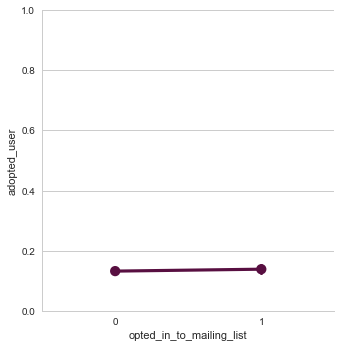

In [12]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=df, x_vars=['opted_in_to_mailing_list'], y_vars='adopted_user', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We see that there is a negligible difference between the two classes. This implies that customers who opted in to mailing list has very little to do with if they ended up being an adopted user.

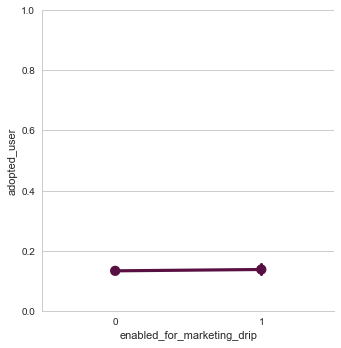

In [13]:
g = sns.PairGrid(data=df, x_vars=['enabled_for_marketing_drip'], y_vars='adopted_user', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

We obtain extremely similar results as above. Unfortunately, the Marketing Drip feature also isn't too helpful in identifying adopted users.

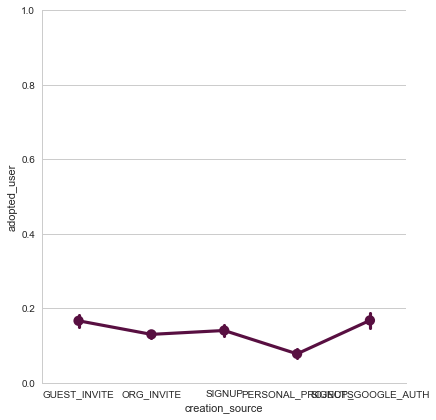

In [14]:
g = sns.PairGrid(data=df, x_vars=['creation_source'], y_vars='adopted_user', size=6)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

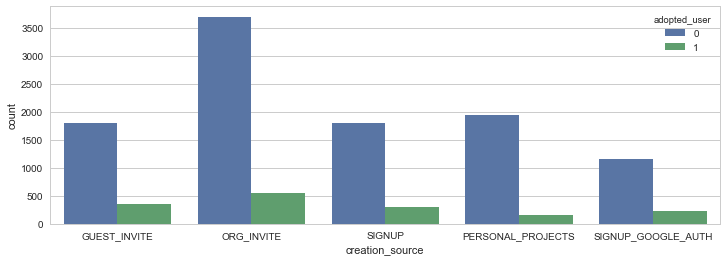

In [15]:
plt.figure(figsize=(12,4))
sns.countplot(x='creation_source', data=df, hue='adopted_user')

People with **Personal Projects** are extremely less likely to be an adopted user as compared to other creation source methods. But since this does not help us in identifying adopted users, this too, isn't a very useful feature.

In [16]:
df['invited'] = df['object_id'].apply(lambda x: 1 if x in invited_users else 0)

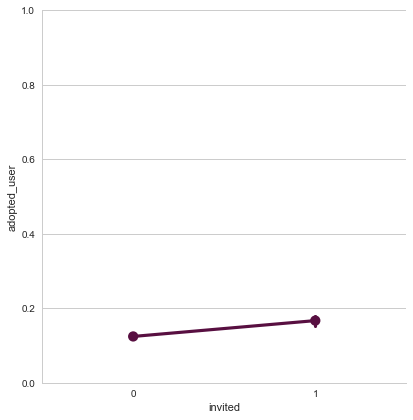

In [17]:
g = sns.PairGrid(data=df, x_vars=['invited'], y_vars='adopted_user', size=6)
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

People who have invited other users have a slightly larger chance of being an adopted user.

In [18]:
def stacked_bar(feature):
    ctab = pd.crosstab([df[feature]], df['adopted_user'], dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab.plot(kind='bar', stacked=True, legend=False)

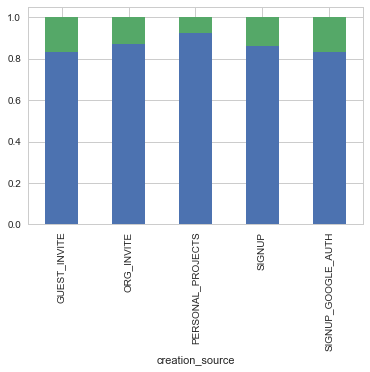

In [19]:
stacked_bar('creation_source')

In [20]:
df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df['email'] = df['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

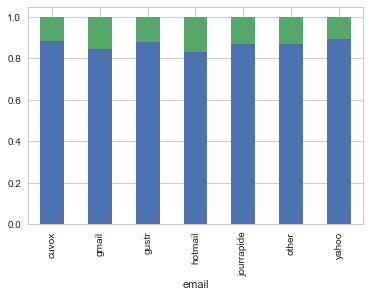

In [21]:
stacked_bar('email')

People who have signed up using **hotmail** are most likely to become adopted users whereas people with **yahoo** IDs are the least likely. However, since the difference is so small, it might be entirely possible that these observations are due to noise.

## Feature Engineering

In [22]:
df = df.set_index('object_id')

In [23]:
df = df.drop('name', axis=1)

In [24]:
df['email'].value_counts().head(10)

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [25]:
df = df.drop('invited_by_user_id', axis=1)

In [26]:
df['org_id'].value_counts().shape

(417,)

In [27]:
df[df['adopted_user'] == 1]['org_id'].value_counts().shape

(400,)

In [28]:
df = df.drop('org_id', axis=1)

In [29]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

In [30]:
df = df.drop('creation_time', axis=1)

In [31]:
df['year'] = df['year'].astype('str')
df['month'] = df['month'].astype('str')

In [32]:
df = pd.get_dummies(df, prefix='is')

In [36]:
df = df.drop('last_session_creation_time', axis=1)

## Machine Learning

In [37]:
X, y = df.drop('adopted_user', axis=1), df['adopted_user']

In [38]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [39]:
classifier = GradientBoostingClassifier(verbose=True)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           0.7817            1.57s
         2           0.7779            1.38s
         3           0.7747            1.59s
         4           0.7720            1.50s
         5           0.7696            1.44s
         6           0.7676            1.39s
         7           0.7658            1.31s
         8           0.7641            1.26s
         9           0.7627            1.22s
        10           0.7615            1.17s
        20           0.7536            0.99s
        30           0.7490            0.80s
        40           0.7459            0.65s
        50           0.7436            0.53s
        60           0.7416            0.43s
        70           0.7399            0.32s
        80           0.7383            0.21s
        90           0.7369            0.10s
       100           0.7356            0.00s


0.86611111111111116

In [40]:
confusion_matrix(test_y, classifier.predict(test_X))

array([[1559,    1],
       [ 240,    0]])

In [41]:
classifier.feature_importances_

array([ 0.02568525,  0.0336144 ,  0.05631585,  0.0334542 ,  0.01824547,
        0.04992706,  0.0420322 ,  0.03760281,  0.0578385 ,  0.02101841,
        0.04042778,  0.02838164,  0.04834698,  0.04843767,  0.0353997 ,
        0.01634881,  0.00963274,  0.01353804,  0.03676286,  0.01620374,
        0.01819921,  0.03383055,  0.04922026,  0.02035079,  0.02493656,
        0.02566703,  0.04260127,  0.03222399,  0.03566445,  0.04809179])